<h1 style="font-size: 36px; color: #FFD700">4 - Training a Classifier</h1>

Đối với dữ liệu cho việc huấn luyện: Có thể ta sẽ phải xử lý hình ảnh, âm thanh, văn bản, video, ta có thể dùng các package tiêu chuẩn để tải dữ liệu vào một mảng numpy. Sau đó ta có thể chuyển thành tensor với `torch.*Tensor`
- Image: Pillow, OpenCV
- Sound: Scipy, librosa
- Text: tải dựa trên Python hoặc raw-Cython hoặc NTLK và SpaCy 

Đối với Vision, torch có `torchvision`, có trình tải data cho các tập dữ liệu phổ biến như ImageNet, CIFAR10, MNIST, v.v và trình chuyển đổi dữ liệu cho hình ảnh ví dụ như `torchvision.datasets` và `torch.utils.data.DataLoader`

Trong phần này ta sẽ sử dụng datasets `CIFAR10`. 
- Nó bao gồm các lớp 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
- Các ảnh trong dataset có size 3x32x32
    - hình ảnh màu 3 kênh màu
    - size 32x32 pixel

### `Training "image classifier"`

Ta sẽ thực hiện theo các bước sau theo thứ tự
1. Tải và chuẩn hóa các tập dữ liệu đào tạo và thử nghiệm `CIFAR10` bằng cách sử dụng `torchvision`
2. Định nghĩa mạng nơ-ron tích chập `CNN`
3. Xác định `loss functions`
4. Đào tạo mạng trên dữ liệu đào tạo
5. Kiểm tra mạng trên dữ liệu thử nghiệm

`1`. `Load and normalize CIFAR10`

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

`Vì sao PILImage lại có phạm vi [0, 1] ?`

Cách đưa PILImage có range [0, 1]
- Theo mặc định ảnh kỹ thuật số thường lưu trữ giá trị pixal mỗi kênh màu dưới dạng số nguyên 8-bit nên phạm vi mặc định là [0, 255]
    - 0: Mức tối thiểu - đen tuyệt đối
    - 255: Mức tối đa - sáng nhất
- Trong code khi ta load dataset thường có dòng `transform.ToTensor()`, đây là quá trình chuyển từ PILImage thành tensor có nghĩa là tự động chia giá trị pixel cho 255 để đưa chúng về phạm vi [0, 1]

Lý do:
- Phù hợp với tính toán trong neural network: Các phép toán trong Deep Learning hoạt động tốt hơn với float, giá trị [0, 1] giúp tránh gradient explosion/vanishing
    - Các activation function (Sigmoid, Tanh) hoạt động tốt nhất khi đầu vào trong khoảng [0, 1] hoặc [-1, 1]
    - Nếu output quá lớn có thể bị gradient explosion/vanishing
    - Phù hợp với hàm loss và optimization
        - Hầu hết các hàm loss (MSE, Cross-Entropy) và bộ tối ưu (SGD, Adam) được thiết kế để hoạt động tốt với đầu vào được chuẩn hóa
        - Nếu giá trị pixel quá lớn, gradient descent có thể dao động mạnh, dẫn đến khó hội tụ.
- Normalize: giúp data có phân phối đồng đều giúp mô hình hội tụ nhanh hơn


In [3]:
# Load hình
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Một số ảnh trong tập traning

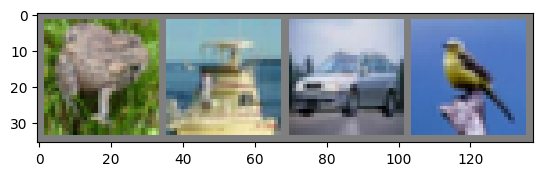

frog  ship  car   bird 


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Hàm show ảnh
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Lấy một số ảnh ngẫu nhiên
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images)) # showw ảnh
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

`2`. `Định nghĩa mạng neural tích chập`

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # Ở đây sẽ là ảnh 3 kênh RGB
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

`Note`
- Conv sẽ trích xuất đặt trưng từ input đầu vào
- Maxpool sẽ giảm chiều dữ liệu 
- Linear sẽ nối các feature đã được trích xuất qua các lớp conv/maxpool

In [11]:
net = Net()

`3`. `Định nghĩa loss_function & optimizer`

Cross Entropy Loss & SGD với momentum

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #Hàm loss 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #optimizer

`4`. `Traning network`

In [17]:
for epoch in range(2):  # loop over the dataset multiple times (lặp qua toàn bộ bộ dữ liệu nhiều lần)
    
    running_loss = 0.0  # khởi tạo giá trị running_loss để lưu trữ tổng lỗi trong mỗi epoch
    for i, data in enumerate(trainloader, 0):  # duyệt qua bộ dữ liệu huấn luyện theo mini-batches
        # get the inputs; data is a list of [inputs, labels] (lấy dữ liệu đầu vào và nhãn)
        inputs, labels = data

        # zero the parameter gradients (đặt lại gradient của các tham số về 0)
        optimizer.zero_grad()

        # forward + backward + optimize (quá trình tính toán forward, tính toán gradient (backward) và tối ưu hóa tham số)
        outputs = net(inputs)  # tính toán kết quả dự đoán từ mô hình
        loss = criterion(outputs, labels)  # tính toán độ lỗi (loss) giữa kết quả dự đoán và nhãn thực tế
        loss.backward()  # tính toán gradient (đạo hàm) của loss theo các tham số mô hình
        optimizer.step()  # cập nhật các tham số mô hình dựa trên gradient tính được

        # print statistics (in các thống kê)
        running_loss += loss.item()  # cộng dồn giá trị lỗi vào running_loss
        if i % 2000 == 1999:    # print every 2000 mini-batches (in ra mỗi 2000 mini-batch)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')  # in giá trị lỗi trung bình trong 2000 mini-batches
            running_loss = 0.0  # đặt lại running_loss về 0 để tính lại cho batch tiếp theo

print('Finished Training')  # khi hoàn thành việc huấn luyện, in thông báo kết thúc

[1,  2000] loss: 0.991
[1,  4000] loss: 1.015
[1,  6000] loss: 1.030
[1,  8000] loss: 1.038
[1, 10000] loss: 1.010
[1, 12000] loss: 1.025
[2,  2000] loss: 0.929


KeyboardInterrupt: 

In [18]:
# save models
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

`5`. `Kiểm tra mạng trên test dataset`

Ta cần phải kiểm tra để xem mạng đã học được điều gì bằng cách dự đoán nhãn lớp mà mạng neural đưa ra và kiểm tra nó so với giá trị thực tế. Nếu dự đoán là đúng, chúng tôi sẽ thêm mẫu vào dánh sách các dự đoán đúng 


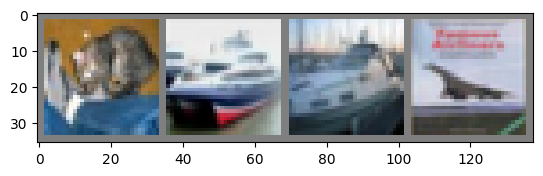

GroundTruth:  cat   ship  ship  plane


In [26]:
dataiter = iter(testloader) # Lấy một mini-batch từ testloader
images, labels = next(dataiter) 

# Hiển thị ảnh trong mini-bathc dạng lưới
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Việc tải lại trong cùng ipynb không cần thiết nhưng nếu sử dụng ở nơi khác thì cần phải load models.

In [ ]:
# net = Net()
# net.load_state_dict(torch.load(PATH, weights_only=True))

In [23]:
outputs = net(images)

Đầu ra là xác suất cho 10 lớp. Xác suất một lớp càng cao thì mạng càng nghĩ rằng hình ảnh thuộc về lớp đó

=> Lấy xác suất cao nhất

In [25]:
# Tìm chỉ số của xác suất cao nhất trong mỗi ảnh (lớp dự đoán)
_, predicted = torch.max(outputs, 1)

# In ra lớp dự đoán của 4 ảnh đầu tiên trong mini-batch
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))


Predicted:  cat   ship  ship  plane


Sau khi test xong thì ta sẽ đưa ra đánh giá để nhận được accuracy của models

In [27]:
# Khởi tạo từ điển để đếm số lượng dự đoán đúng và tổng số dự đoán cho mỗi lớp
correct_pred = {classname: 0 for classname in classes}  # Số dự đoán đúng cho mỗi lớp
total_pred = {classname: 0 for classname in classes}    # Tổng số dự đoán cho mỗi lớp

# Không cần tính toán gradient (chỉ kiểm tra dự đoán)
with torch.no_grad():
    # Duyệt qua từng batch trong testloader
    for data in testloader:
        images, labels = data  # Lấy ảnh và nhãn từ batch
        outputs = net(images)  # Tính toán đầu ra của mạng nơ-ron
        _, predictions = torch.max(outputs, 1)  # Lấy chỉ số lớp dự đoán có năng lượng cao nhất (max)
        
        # Đếm số dự đoán đúng cho mỗi lớp
        for label, prediction in zip(labels, predictions):
            if label == prediction:  # Nếu nhãn thực tế và nhãn dự đoán giống nhau
                correct_pred[classes[label]] += 1  # Tăng số dự đoán đúng cho lớp
            total_pred[classes[label]] += 1  # Tăng tổng số dự đoán cho lớp

# In độ chính xác của mỗi lớp
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]  # Tính độ chính xác (%) cho lớp
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')  # In ra độ chính xác cho từng lớp

Accuracy for class: plane is 55.5 %
Accuracy for class: car   is 71.8 %
Accuracy for class: bird  is 55.6 %
Accuracy for class: cat   is 51.2 %
Accuracy for class: deer  is 56.0 %
Accuracy for class: dog   is 39.7 %
Accuracy for class: frog  is 69.4 %
Accuracy for class: horse is 70.4 %
Accuracy for class: ship  is 74.7 %
Accuracy for class: truck is 75.8 %


`Training in GPU`

Tương tự như cách chuyển tensor sang GPU, ta cũng có thể chuyển mạng neural sang GPU

In [28]:
# định nghĩa thiết bị
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Khi ta dùng `.to(device)` - phương thức này sẽ đệ quy duyệt qua và chuyển đổi các tham số của mô hình thành tensor CUDA

In [29]:
inputs, labels = data[0].to(device), data[1].to(device)

`Exercise`: Hãy thử tăng chiều rộng mạng của bạn (đối số 2 của đối số đầu tiên nn.Conv2dvà đối số 1 của đối số thứ hai nn.Conv2d– chúng cần phải có cùng số), xem tốc độ bạn nhận được là bao nhiêu.